In [156]:
%load_ext autoreload
%autoreload 1

import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.append('../src')

from data.fetch_data import get_submission_docs_for_subreddit
from data.clean_data import process_text
from data.mymongo import get_db

%aimport data.fetch_data
%aimport data.clean_data
%aimport data.mymongo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [284]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 100)

# Load Data

In [121]:
db = get_db()

In [122]:
users_raw = list(db.user_comments.find())

In [123]:
def move_author(x):
    x['author'] = x['_id']['author']
    return x

def process_user_data(user_data):
    users = [move_author(x) for x in user_data]
    data = pd.DataFrame.from_dict(users)
    data = data.drop('_id', axis=1)
    data = data[~data.author.isin(['[deleted]','AutoModerator'])]
    return data[data.num_comments >= 20]

In [124]:
data = process_user_data(users_raw)

# EDA

In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7283 entries, 4 to 21961
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   num_comments                       7283 non-null   int64 
 1   total_comment_length               7283 non-null   int64 
 2   text                               7283 non-null   object
 3   total_comment_score                7283 non-null   int64 
 4   best_comment_score                 7283 non-null   int64 
 5   worst_comment_score                7283 non-null   int64 
 6   number_neg_score_comments          7283 non-null   int64 
 7   number_pos_score_comments          7283 non-null   int64 
 8   total_neg_score                    7283 non-null   int64 
 9   total_pos_score                    7283 non-null   int64 
 10  num_comments_politics              7283 non-null   int64 
 11  num_comments_political_discussion  7283 non-null   int64 
 12  num_c

In [128]:
data['avg_comment_length'] = data.total_comment_length / data.num_comments

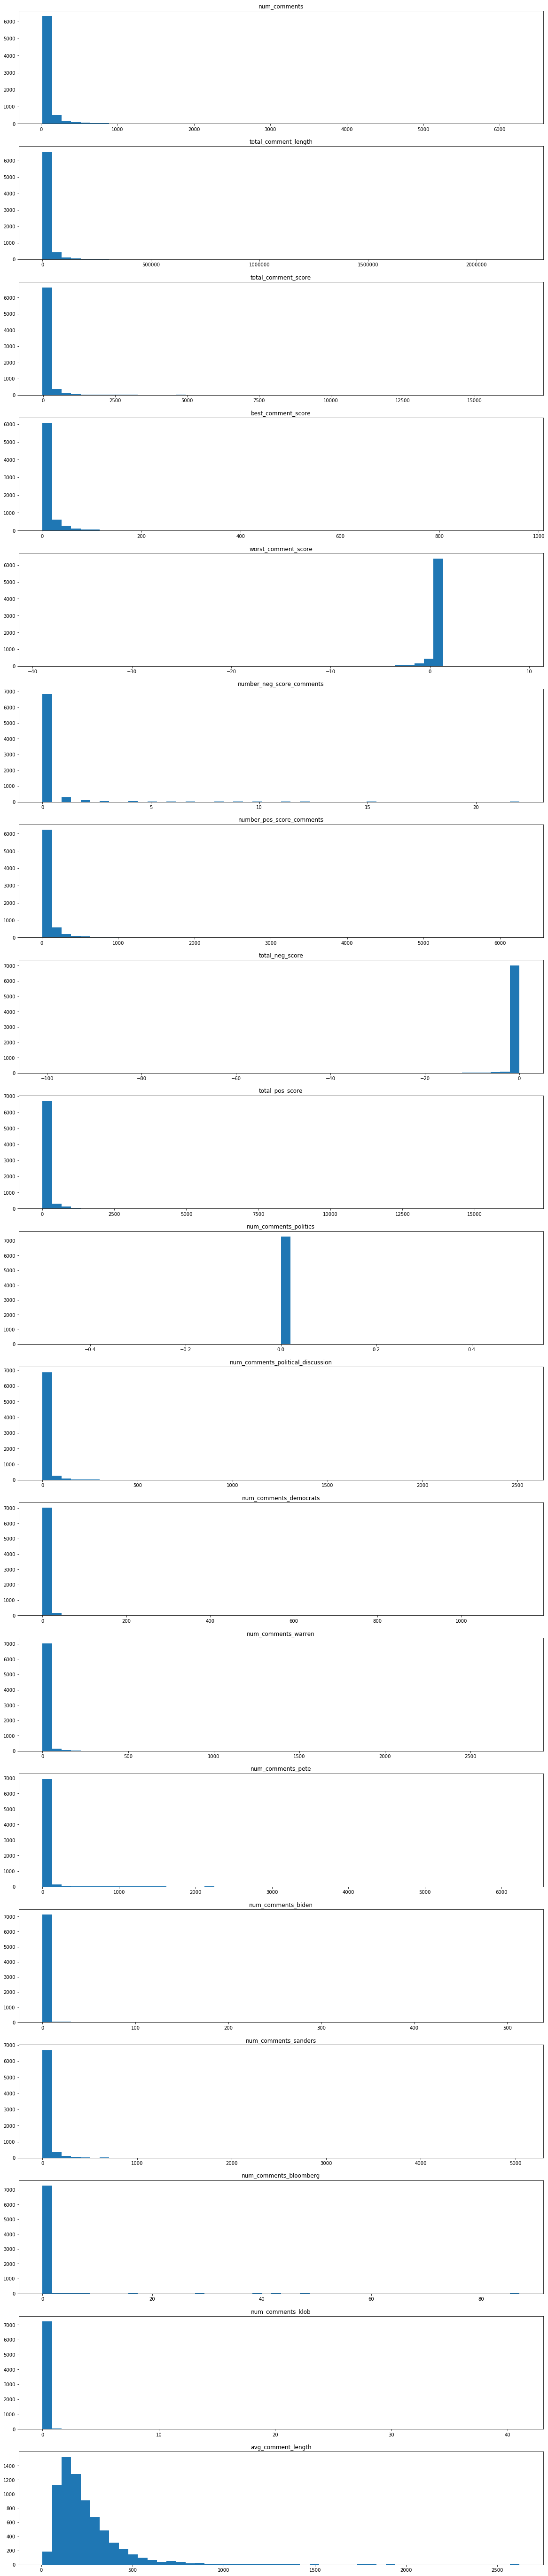

In [139]:
hist_cols = [x for x in data.columns if x != 'text' and x != 'author']
num_hist = len(hist_cols)

plt.figure(figsize=(20, 100))

for i, col in enumerate(hist_cols):
    plt.subplot(num_hist, 1, i+1)
    plt.hist(data[col], bins=50)
    plt.title(col)
    

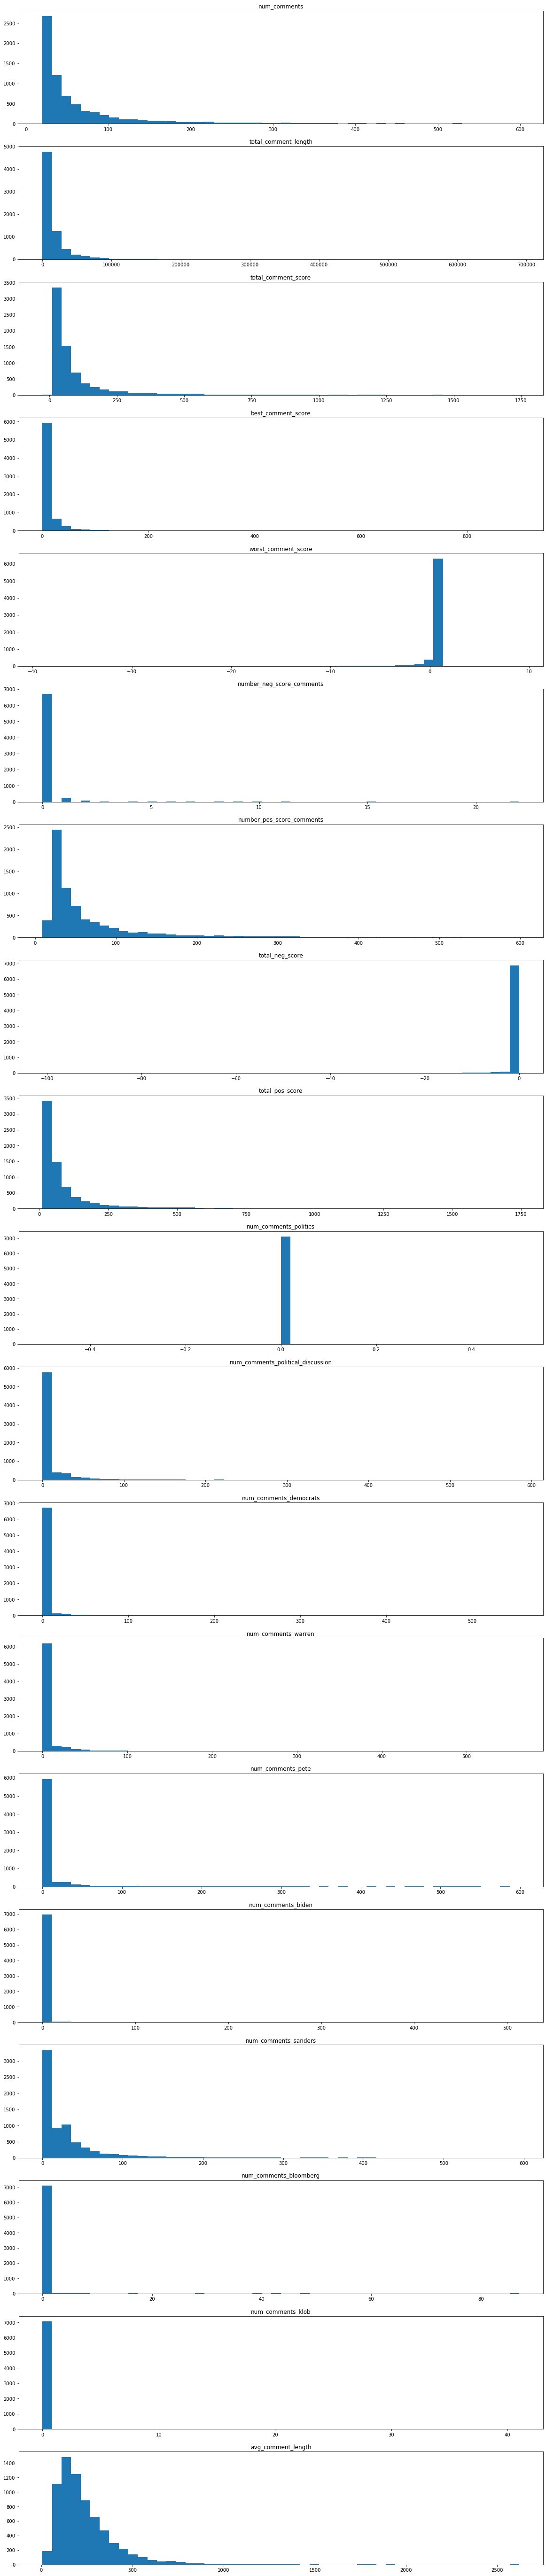

In [141]:
hist_cols = [x for x in data.columns if x != 'text' and x != 'author']
num_hist = len(hist_cols)

plt.figure(figsize=(20, 100))

for i, col in enumerate(hist_cols):
    plt.subplot(num_hist, 1, i+1)
    plt.hist(data[data.num_comments < 600][col], bins=50)
    plt.title(col)
    

In [142]:
data.sort_values('num_comments').tail(15)

,num_comments,total_comment_length,text,total_comment_score,best_comment_score,worst_comment_score,number_neg_score_comments,number_pos_score_comments,total_neg_score,total_pos_score,...,num_comments_political_discussion,num_comments_democrats,num_comments_warren,num_comments_pete,num_comments_biden,num_comments_sanders,num_comments_bloomberg,num_comments_klob,author,avg_comment_length
12148,2700,375827,"[Pete says “evening” weird. E-ve-ning, Meh, it...",7293,81,1,0,2700,0,7293,...,0,0,0,2700,0,0,0,0,apieceofloam,139.195185
1911,2722,659866,"[Such a nice young man!, when did Pete give a ...",4860,53,1,0,2722,0,4860,...,0,0,0,2722,0,0,0,0,CastellessKing,242.419544
21879,2790,771535,[&gt; N. Gregory Mankiw is the Robert M. Beren...,3913,80,-4,3,2777,-7,3920,...,0,1,2785,1,0,3,0,0,zdss,276.535842
13391,3067,574721,"[Omg, my heart! 🥰, Presidential debate in New ...",7404,89,1,0,3067,0,7404,...,0,0,0,3067,0,0,0,0,coldlibrarian,187.388653
11462,3777,455833,"[You can meet with my group! Send me a DM, Fai...",5037,150,-1,1,3774,-1,5038,...,0,0,28,14,1,3734,0,0,Yintrovert,120.686524
4169,3789,1259354,"[Hello oi_peiD. We are sorry, but your submiss...",4182,82,0,0,3786,0,4182,...,0,0,0,0,0,3789,0,0,GrandpaChainz,332.371074
18507,3966,860578,[Right but like... we know his stance because ...,8828,167,1,0,3966,0,8828,...,0,0,0,3966,0,0,0,0,piquedd34,216.988906
16291,3970,954185,"[It's still on BerniePB, You're welcome to com...",4971,200,0,0,3967,0,4971,...,0,0,4,0,0,3966,0,0,justcasty,240.348866
3577,4017,698685,"[just donated 5 dollars, she's my distant seco...",7991,75,-1,2,4013,-2,7993,...,1,0,300,3716,0,0,0,0,FatCatInTightPlaces,173.932039
18382,4040,953810,[We'll find out. The others had the luxury of ...,6023,51,1,0,4040,0,6023,...,0,0,0,4040,0,0,0,0,pdanny01,236.091584


# Get Sentiment

In [148]:
sent_series = data.text.map(lambda comments: [analyzer.polarity_scores(x)['compound'] for x in comments])

In [149]:
sent_series

4        [0.0, 0.8346, 0.2551, 0.7149, 0.0, 0.4404, 0.5...
6        [0.4939, 0.0, 0.5719, -0.1419, 0.6597, 0.3182,...
11       [0.0, 0.4926, 0.6428, -0.0608, 0.1027, 0.1655,...
17       [-0.3818, 0.9186, 0.9239, 0.7845, 0.1511, -0.0...
19       [-0.6597, 0.0, 0.0, 0.4404, -0.5423, 0.4019, -...
                               ...                        
21953    [-0.3655, 0.887, 0.0, -0.9736, -0.8158, -0.440...
21954    [0.0, 0.986, 0.7096, 0.7133, 0.0772, 0.923, 0....
21957    [0.0, 0.5836, 0.0772, 0.0, -0.6147, 0.0, 0.0, ...
21960    [0.0, 0.3499, 0.3182, 0.0772, 0.4019, 0.5106, ...
21961    [-0.9455, -0.8953, -0.8271, -0.9281, -0.7279, ...
Name: text, Length: 7283, dtype: object

In [151]:
data['text_sentiment'] = sent_series

In [152]:
import pickle

with open('user_comments_with_sentiment.pickle', 'wb') as write_file:
    pickle.dump(data, write_file)

# Get Tone

In [154]:
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [161]:
IBM_API_KEY = os.environ['IBM_API_KEY']

authenticator = IAMAuthenticator(IBM_API_KEY)
tone_analyzer = ToneAnalyzerV3(
    version='2020-02-25',
    authenticator=authenticator
)

tone_analyzer.set_service_url('https://api.us-south.tone-analyzer.watson.cloud.ibm.com/instances/421d8d20-ab81-4291-a7ba-0e37f6cbf9de')

In [247]:
import time

def comments_to_text(comments):
    size = np.min([50, len(comments)])
    comments_to_tone = np.random.choice(comments, size=size, replace=False)
    return ' '.join(comments)

def get_tone(comments):
#     time.sleep(0.2)
    try:
        tone_text = comments_to_text(comments)
        resp = tone_analyzer.tone(
            {'text': tone_text},
            content_type='application/json',
            sentences=True
        )
        if resp.status_code == 200:
            return resp.result
        else:
            return {'error': resp.status_code}
    except Exception as e:
        return {'error': e}
    


In [253]:
raw_tone_series = data_raw.text.map(get_tone)

ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: be86c1153251ec58fa8f02989ab4f6a7
ERROR:root:Request Entity Too Large
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Request Entity Too Large, Code: 413
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_

ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: 754f280e1f7bfa23e5d9fe3caa53192f
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: e9f7fad055b4455970d7e19c8e491bbb
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (mos

ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: 8ae6c3b174d1e71d08abe89a467a5268
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: e854ffcf31220c931107efc72f332491
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (mos

ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: dcc652abcda2061fae0baaaa924c9cb4
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: 83eadd95c8d54c9ad26de6f116423eee
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (mos

ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: e5f33fb533730fc45a7018121d80a286
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: 1999fec31b3dc422bec3f1bf1331c5dd
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (mos

ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: fe999edf40ba08658f62c45f1bdc77c4
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: ff0a844ac68bbd93a5c456302ae76465
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (mos

ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: f9e8484879bc1d9859e2e615e0446753
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: e400b2a13fc38e40a201074f4bf35b95
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (mos

ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: 071ed88b093badbaaa0f6377244fabe4
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: 2d31b9d0c016ba4d33b122a8e079c590
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (mos

ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: c2f32b8952a0f7a9fee21656c1e77e7d
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: c34e50c11976e3ff7978b049f7692ead
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (mos

ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: 5c0d34f55017852cc96838aaae04de6d
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: 418f8d4abfd1741c0d497b0077c427a0
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (mos

ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: 5441a5244e5141dfff384a123330b75f
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: 3de998895c930a23cebaa4d84ffbc637
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (mos

In [254]:
import pickle
with open('raw_tone_results.pickle', 'wb') as write_file:
    pickle.dump(raw_tone_series, write_file)

In [270]:
raw_keys = 

In [276]:
first_keys = raw_keys.map(lambda x: list(x)[0])

In [285]:
raw_tone_series[raw_tone_series.map(lambda x: list(x.keys())[0]) == 'error']

23       {'error': Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transactio...
37                                                     {'error': Error: Request Entity Too Large, Code: 413}
48       {'error': Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transactio...
91       {'error': Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transactio...
400      {'error': Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transactio...
454      {'error': Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transactio...
496      {'error': Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transactio...
513      {'error': Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transactio...
612      {'error': Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transactio...
662      {'error': 

In [196]:
from functools import reduce

def process_doc_tone(acc, next_tone):
    acc[next_tone['tone_id']] = next_tone['score']
    return acc
    
reduce(process_doc_tone, all_comm_test.result['document_tone']['tones'], {})

{'sadness': 0.530624, 'joy': 0.605186, 'tentative': 0.558377}

In [197]:
all_comm_test.result['document_tone']['tones']

[{'score': 0.530624, 'tone_id': 'sadness', 'tone_name': 'Sadness'},
 {'score': 0.605186, 'tone_id': 'joy', 'tone_name': 'Joy'},
 {'score': 0.558377, 'tone_id': 'tentative', 'tone_name': 'Tentative'}]